In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, BatchNormalization, Dropout, Input, Lambda, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetB0, MobileNetV2
import tensorflow.keras.backend as K

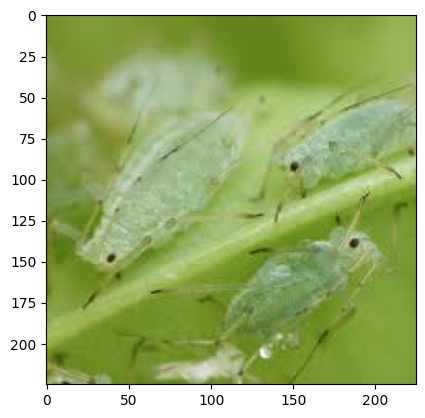

In [27]:
# Load and Display Image
img_path = 'Dataset/pest/train/aphids/jpg_0 - Copy (2).jpg'
if os.path.exists(img_path):
    img = cv2.imread(img_path)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
else:
    print(f"Warning: Image path {img_path} not found. Skipping display.")


In [28]:
train_dir = 'Dataset/pest/train'
test_dir = 'Dataset/pest/test'

In [29]:
# Image Data Generator
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    zca_epsilon=1e-06,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.2,
    shear_range=20,
    zoom_range=0.8,
    fill_mode="nearest",
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.05,
    rescale=1./255  # Add rescaling to normalize pixel values
)


In [30]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [31]:
# Load data
training = train_datagen.flow_from_directory(
    train_dir, 
    batch_size=32, 
    target_size=(224, 224), 
    subset="training"
)


Found 2565 images belonging to 9 classes.


In [32]:
validing = train_datagen.flow_from_directory(
    train_dir, 
    batch_size=32, 
    target_size=(224, 224), 
    subset='validation', 
    shuffle=True
)

Found 135 images belonging to 9 classes.


In [33]:
testing = test_datagen.flow_from_directory(
    test_dir, 
    batch_size=32, 
    target_size=(224, 224), 
    shuffle=True
)

Found 450 images belonging to 9 classes.


In [34]:
# Get number of classes
num_classes = len(training.class_indices)
print(f"Number of classes: {num_classes}")
print(f"Class mapping: {training.class_indices}")

Number of classes: 9
Class mapping: {'aphids': 0, 'armyworm': 1, 'beetle': 2, 'bollworm': 3, 'grasshopper': 4, 'mites': 5, 'mosquito': 6, 'sawfly': 7, 'stem_borer': 8}


In [35]:
# Build a model with MobileNetV2 (more compatible across TF versions)
def build_model():
    # Use MobileNetV2 as base model
    base_model = MobileNetV2(weights='imagenet', 
                            include_top=False, 
                            input_shape=(224, 224, 3))
    
    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False
    
    # Create the model
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    
    # Compile the model
    model.compile(
        optimizer=Adam(0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [36]:
# Train and evaluate function
def train_and_evaluate():
    # Dictionary to store results
    results = {}
    models = {}
    
    # Build and train the model
    print("Training model...")
    model = build_model()
    history = model.fit(
        training,
        validation_data=validing,
        epochs=20,
        callbacks=[
            EarlyStopping(patience=5, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
        ],
        verbose=2
    )
    
    # Evaluate on test data
    test_loss, test_acc = model.evaluate(testing)
    
    # Store results
    model_name = "MobileNetV2_Transfer"
    results[model_name] = test_acc
    models[model_name] = model
    
    # Save model
    model.save(f"{model_name}.h5")
    print(f"Model Test Accuracy: {test_acc * 100:.2f}%")
    
    return results, models


Starting training...
Training model...


c:\Hemanth\Mini Project\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
81/81 - 84s - 1s/step - accuracy: 0.4152 - loss: 1.8775 - val_accuracy: 0.6222 - val_loss: 1.1355 - learning_rate: 1.0000e-03
Epoch 2/20
81/81 - 65s - 806ms/step - accuracy: 0.5279 - loss: 1.4323 - val_accuracy: 0.6444 - val_loss: 1.1510 - learning_rate: 1.0000e-03
Epoch 3/20
81/81 - 65s - 804ms/step - accuracy: 0.5879 - loss: 1.2562 - val_accuracy: 0.6222 - val_loss: 1.1688 - learning_rate: 1.0000e-03
Epoch 4/20
81/81 - 60s - 738ms/step - accuracy: 0.6226 - loss: 1.1508 - val_accuracy: 0.6148 - val_loss: 1.2089 - learning_rate: 1.0000e-03
Epoch 5/20
81/81 - 55s - 677ms/step - accuracy: 0.6441 - loss: 1.0405 - val_accuracy: 0.6889 - val_loss: 1.0250 - learning_rate: 5.0000e-04
Epoch 6/20
81/81 - 82s - 1s/step - accuracy: 0.6647 - loss: 0.9765 - val_accuracy: 0.6593 - val_loss: 1.0439 - learning_rate: 5.0000e-04
Epoch 7/20
81/81 - 46s - 563ms/step - accuracy: 0.6593 - loss: 0.9735 - val_accuracy: 0.6889 - val_loss: 0.9981 - learning_rate: 5.0000e-04
Epoch 8/20
81/81 - 39s - 4

Model Test Accuracy: 88.22%
Best model is MobileNetV2_Transfer with accuracy 88.22%


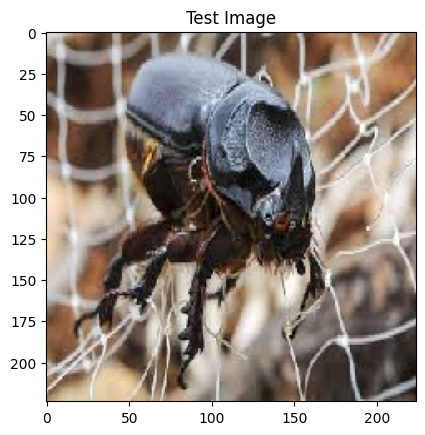

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

Best Model (MobileNetV2_Transfer) Predicted Class: beetle


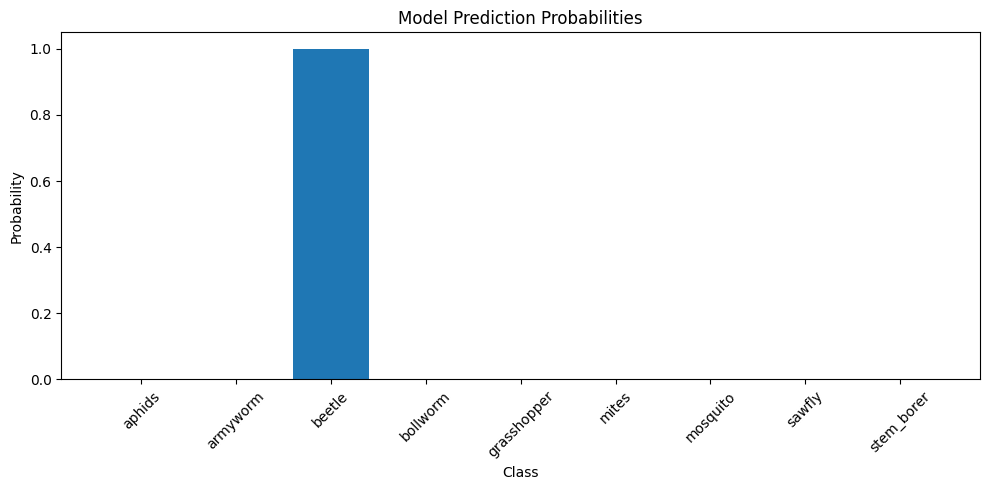

In [37]:
# Train and get the models
try:
    print("Starting training...")
    results, models = train_and_evaluate()
    best_model_name = max(results, key=results.get)
    best_model = models[best_model_name]
    print(f"Best model is {best_model_name} with accuracy {results[best_model_name] * 100:.2f}%")
    
    # Test on a single image
    img_test_path = 'Dataset/pest/test/beetle/jpg_33.jpg'
    if os.path.exists(img_test_path):
        # Load and preprocess the image
        img_test = image.load_img(img_test_path, target_size=(224, 224))
        plt.imshow(img_test)
        plt.title("Test Image")
        plt.show()
        
        img_array = image.img_to_array(img_test)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255.0
        
        # Get class labels
        class_labels = list(training.class_indices.keys())
        
        # Make predictions
        prediction = best_model.predict(img_array)
        predicted_class = np.argmax(prediction, axis=1)
        
        print(f"\nBest Model ({best_model_name}) Predicted Class: {class_labels[predicted_class[0]]}")
        
        # Display prediction probabilities
        plt.figure(figsize=(10, 5))
        plt.bar(class_labels, prediction[0])
        plt.xlabel("Class")
        plt.ylabel("Probability")
        plt.title(f"Model Prediction Probabilities")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig('model_prediction.png')
        plt.show()
    else:
        print(f"Warning: Test image path {img_test_path} not found. Skipping prediction.")

except Exception as e:
    print(f"An error occurred: {e}")
    print("Here's the full traceback:")
    import traceback
    traceback.print_exc()